In [294]:
from typing import Any
from rich.console import Console
from rich.table import Table

import numpy as np
import matplotlib.pyplot as polt

from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from sklearn import linear_model
import statsmodels.api as sm

console = Console()

In [295]:
# Размерность (до возведения в квадрат): 10^(-2) мм
experiment_values: dict[str, dict[str, Any]] = {
  "yellow": {
    "bright": np.array([17, 27, 34.5, 40, 45, 49.5, 53.5, 57, 61, 64, 67.5, 70, 73, 76, 78.5, 81, 83.5, 86, 88, 90.5]),
    "dark": np.array([23, 31, 37.5, 43, 47.5, 51.5, 55.5, 59.5, 62.5, 66, 68.5, 72, 74.5, 77, 80, 82.5, 84.5, 87, 89.5, 91.5]),
  },
  "red": {
    "bright": np.array([91.5, 100, 106, 111, 115.5, 120, 124.3, 128, 131.5, 135, 138, 140.5, 143, 146.5, 149.5]),
    "dark": np.array([96, 103.5, 109, 114, 118.5, 122, 126, 130, 133.5, 136, 139.5, 142, 145, 148, 151])
  },
  #
  "green": {
    "bright": np.array([17, 27, 33, 38, 43, 47, 51, 54, 57, 60, 63, 66, 69, 72, 74, 77, 79, 81, 83, 85]),
    "dark": np.array([23, 30, 36, 41, 45, 49, 53, 56, 59, 62, 65, 68, 71, 73, 75, 78, 80, 82, 85, 87])
  },
  "blue": {
    "bright": np.array([18, 26, 31, 36, 41, 44, 47, 50, 53, 56]),
    "dark": np.array([22, 29, 34, 38, 42, 46, 49, 52, 55, 58])
  }
}

centers: dict[str, float] = {
  "yellow": 1,
  "red": 66,
  "green": -5,
  "blue": -5
}

In [296]:
# Размерность (после возведения в квадрат): 10^(-4) мм^2
for color in experiment_values.keys():
  experiment_values[color]["bright"] -= centers[color]
  experiment_values[color]["bright"] **= 2

  experiment_values[color]["dark"] -= centers[color]
  experiment_values[color]["dark"] **= 2

# print(experiment_values)

In [297]:
# Размерность: мм^2 (смотри код)
mnk_coefs: dict[str, dict[str, float]] = {
  "yellow": {},
  "red": {},
  "green": {},
  "blue": {}
}

# Размерность: мм^2 (смотри код)
mnk_coefs_errors: dict[str, dict[str, float]] = {
  "yellow": {},
  "red": {},
  "green": {},
  "blue": {}
}

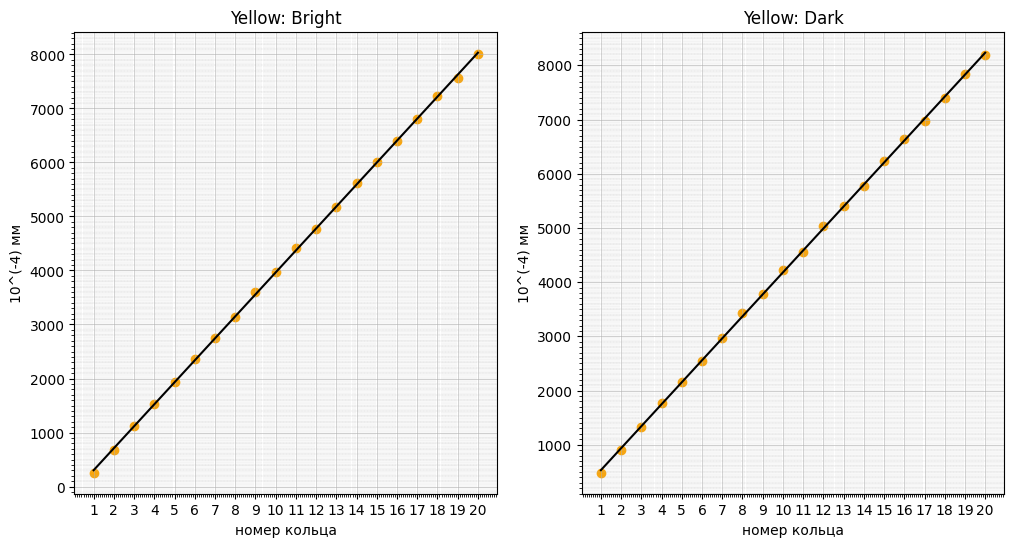

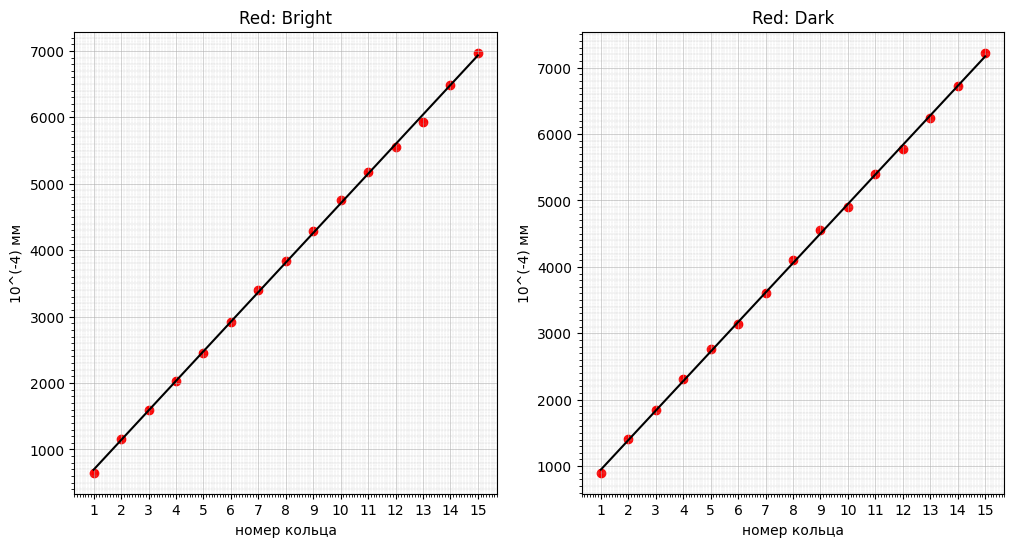

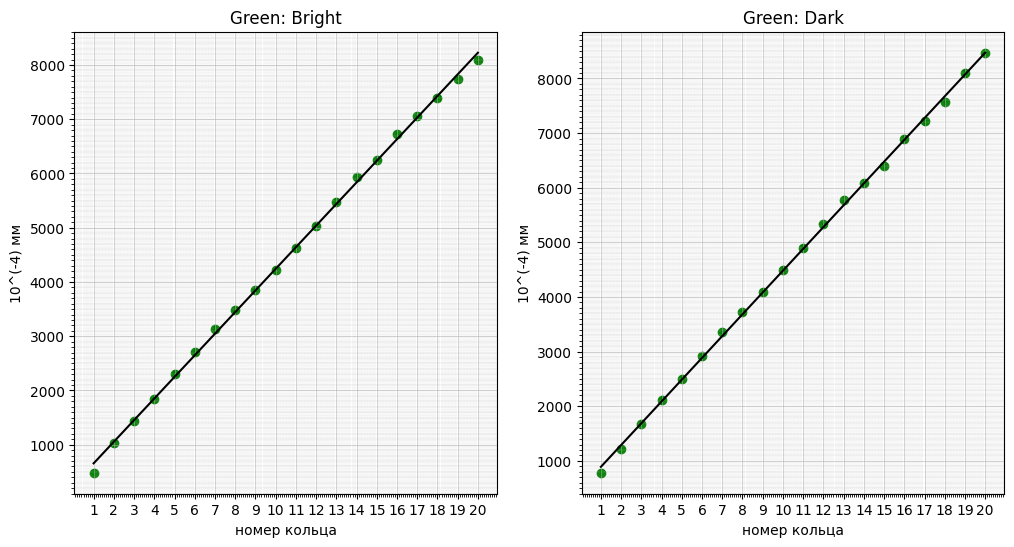

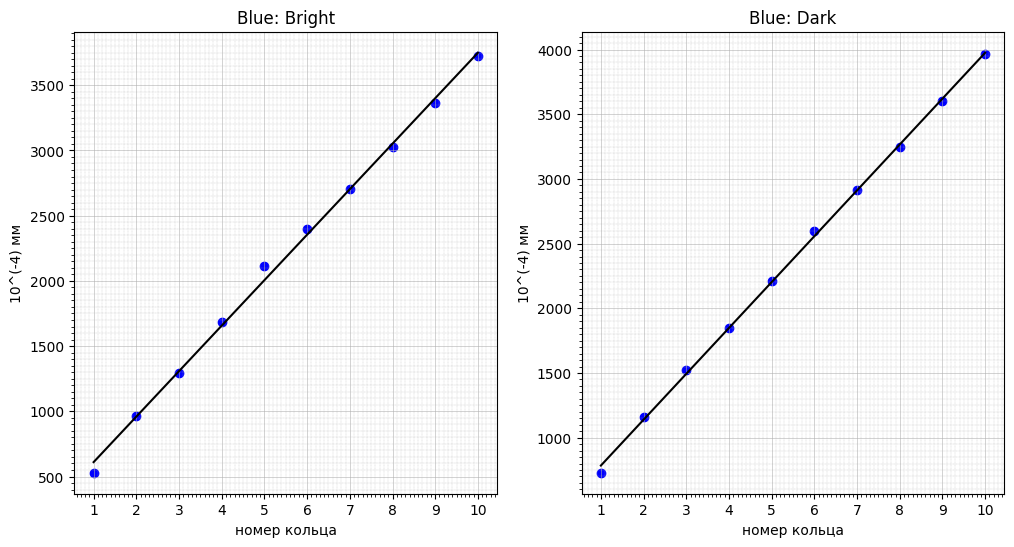

In [298]:
for color in experiment_values.keys():
  _, (ax_1, ax_2) = polt.subplots(1, 2, figsize=(12, 6))

  for ax, brightness in zip((ax_1, ax_2), experiment_values[color].keys()):
    m_points = np.arange(1, len(experiment_values[color][brightness]) + 1)

    OLS = linear_model.LinearRegression()
    OLS.fit(X=m_points.reshape(-1, 1), y=experiment_values[color][brightness])

    X_sm = sm.add_constant(m_points)
    model_sm = sm.OLS(experiment_values[color][brightness], X_sm)
    results_sm = model_sm.fit()

    # Размерность: мм^2 (после домножения)
    mnk_coefs[color][brightness] = results_sm.params[-1] * 10**(-4)
    mnk_coefs_errors[color][brightness] = results_sm.bse[-1] * 10**(-4)

    # Размерность: мм^2 (после домножения)
    # mnk_coefs[color][brightness] = OLS.coef_[-1] * 10**(-4)

    ax.set_title(f"{color.capitalize()}: {brightness.capitalize()}")

    ax.set_xlabel('номер кольца')
    ax.set_ylabel('10^(-4) мм')

    ax.scatter(m_points,
               experiment_values[color][brightness],
               color=color if color != "yellow" else "orange",
               label="Эксперимент")

    ax.plot(m_points,
            OLS.predict(m_points.reshape(-1, 1)),
            color="black",
            label="МНК")

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))

    ax.grid(which='minor', linestyle='--', linewidth=0.2)
    ax.grid(which='major', linewidth=0.4)
    # ax.legend()


polt.show()

In [299]:
table = Table(title="MNK Coefficients")

table.add_column("Color", justify="center")

for color in mnk_coefs.keys():
  table.add_column(color.capitalize(), justify="center")

for brightness in ("bright", "dark"):
  table.add_row(brightness.capitalize(),
                *[f"k = {mnk_coefs[color][brightness]:.5f} мм^2" for color in mnk_coefs.keys()])

console.print(table)

                                   MNK Coefficients                                   
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Color  ┃      Yellow      ┃       Red        ┃      Green       ┃       Blue       ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Bright │ k = 0.04068 мм^2 │ k = 0.04455 мм^2 │ k = 0.03984 мм^2 │ k = 0.03488 мм^2 │
│  Dark  │ k = 0.04053 мм^2 │ k = 0.04445 мм^2 │ k = 0.03989 мм^2 │ k = 0.03546 мм^2 │
└────────┴──────────────────┴──────────────────┴──────────────────┴──────────────────┘

In [ ]:
# table = Table(title="MNK Coefficients Errors")

# table.add_column("Color", justify="center")

# for color in mnk_coefs_errors.keys():
#   table.add_column(color.capitalize(), justify="center")

# for brightness in ("bright", "dark"):
#   table.add_row(brightness.capitalize(),
#                 *[f"k = {mnk_coefs_errors[color][brightness]:.5f} мм^2" for color in mnk_coefs_errors.keys()])

# console.print(table)

                               MNK Coefficients Errors                                
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Color  ┃      Yellow      ┃       Red        ┃      Green       ┃       Blue       ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Bright │ k = 0.00011 мм^2 │ k = 0.00027 мм^2 │ k = 0.00027 мм^2 │ k = 0.00061 мм^2 │
│  Dark  │ k = 0.00013 мм^2 │ k = 0.00024 мм^2 │ k = 0.00022 мм^2 │ k = 0.00032 мм^2 │
└────────┴──────────────────┴──────────────────┴──────────────────┴──────────────────┘

$$
r_m = \sqrt{m  R  \lambda} \qquad
\begin{aligned}
  r_m^2 = mR\lambda, \qquad  m = 1\qquad \\
  r^2 = kx + b,\qquad x = 1,b = 0 \\
\end{aligned}\qquad , \qquad
⇒\qquad
\begin{aligned}
  R\lambda=k \\
  R=\frac{k}{\lambda} \\
\end{aligned}
$$

In [301]:
# Размерность: мм
optical_lambda: dict[str, float] = {
  "yellow": 575 * 10**(-6),
  "red": 700 * 10**(-6),
  "blue": 465 * 10**(-6),
  "green": 530 * 10**(-6)
}

# Размерность: мм
R: dict[str, dict[str, float]] = {
  "yellow": {},
  "red": {},
  "green": {},
  "blue": {}
}

# Размерность: мм
R_errors: dict[str, dict[str, float]] = {
  "yellow": {},
  "red": {},
  "green": {},
  "blue": {}
}

for color in optical_lambda.keys():
  for brightness in experiment_values[color].keys():
    R[color][brightness] = mnk_coefs[color][brightness] / optical_lambda[color]
    R_errors[color][brightness] = mnk_coefs_errors[color][brightness] / optical_lambda[color]

In [302]:
table = Table(title="R: радиус кривизны линзы")

table.add_column("Color", justify="center")

for color in R.keys():
  table.add_column(color.capitalize(), justify="center")

for brightness in ("bright", "dark"):
  table.add_row(brightness.capitalize(),
                *[f"R = {R[color][brightness]:.2f} ± {R_errors[color][brightness]:.2f} мм" for color in R.keys()])

console.print(table)

                                     R: радиус кривизны линзы                                     
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Color  ┃       Yellow        ┃         Red         ┃        Green        ┃        Blue         ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Bright │ R = 70.74 ± 0.19 мм │ R = 63.64 ± 0.39 мм │ R = 75.17 ± 0.52 мм │ R = 75.01 ± 1.31 мм │
│  Dark  │ R = 70.49 ± 0.22 мм │ R = 63.50 ± 0.34 мм │ R = 75.27 ± 0.42 мм │ R = 76.25 ± 0.69 мм │
└────────┴─────────────────────┴─────────────────────┴─────────────────────┴─────────────────────┘

## 3) Биения

![](./pictures/KDI.jpg)

![](./pictures/NIS.jpg)

## $ \text{4) Доплеровская ширина} $
$$
T = 900 \, K; \qquad \frac{\Delta\lambda}{\lambda} = ? \\
\frac{\Delta\lambda}{\lambda} ≈ \frac{V_m}{c} - эффект \, Доплера \\
V_m = \sqrt{\frac{8RT}{\pi\mu}}, \, \mu  = 200.6 \, \frac{г}{моль} \, (ртуть); \, V_m=308.7 \, \frac{м}{с} \\ 
\frac{\Delta\lambda}{\lambda} ≈ 10^{-6}
$$